## Setup

In [1]:
!git clone https://github.com/fastai/course22p2
%cd course22p2
!pip install -e .

d:\github\course22p2\course22p2


Cloning into 'course22p2'...


Obtaining file:///D:/github/course22p2/course22p2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: miniai
    Found existing installation: miniai 0.0.1
    Uninstalling miniai-0.0.1:
      Successfully uninstalled miniai-0.0.1
  Running setup.py develop for miniai


## Custom Sampler

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(15)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [185]:
xl,yl = 'image','label'
name = "mnist"
bs = 256 # 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)

  0%|          | 0/2 [00:00<?, ?it/s]

In [186]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

In [187]:
class TopLossesCallback(Callback):
  epoch_preds = []
  epoch_targets = []
  
  @torch.no_grad()
  def _calculate_top_losses(self):
    preds = torch.cat(self.epoch_preds, dim=0)
    targets = torch.cat(self.epoch_targets, dim=0)
    losses = F.cross_entropy(preds, targets, reduce=False)
    return torch.topk(losses, preds.shape[0]).indices

  def after_batch(self, learn):
    if not learn.model.training:
      return
    self.epoch_preds.append(learn.preds)
    self.epoch_targets.append(learn.batch[1])

  def before_epoch(self, learn):
    self.epoch_preds = []
    self.epoch_targets = []

  def after_epoch(self, learn):
    if not learn.model.training:
      return
    learn.dls.train.sampler.top_losses = self._calculate_top_losses()


class CustomTrainingSampler(WeightedRandomSampler):
  def __init__(self, *args, **kwargs):
    WeightedRandomSampler.__init__(self, *args, **kwargs)
    self.data_indexes_for_epoch = []
    self.top_losses = []
    self.epoch = -1
    self.n = {
        0: 0,
        1: 0,
        # Before the 2nd epoch drop 10% of the training dataset with the lowest losses.
        # Replace them with the 10% of the training dataset with the highest losses.
        # This gives the model two opportunities to train on the most challenging images.
        2: 0.10,
        3: 0,
        4: 0,
        5: 0,
        6: 0
    }

  def __iter__(self) -> Iterator[int]:
    self.epoch += 1
    rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
    try:
      n = int(self.n[self.epoch] * self.num_samples)

      if n != 0:
        # TODO: Cleanup the code below
        inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()
        self.data_indexes_for_epoch = torch.tensor(self.data_indexes_for_epoch).cpu()
        self.data_indexes_for_epoch[self.top_losses[-n:].cpu()] = self.data_indexes_for_epoch[inverted_losses_for_epochs]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch[rand_tensor]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch.tolist()
      else:
        self.data_indexes_for_epoch = rand_tensor
    except:
      self.data_indexes_for_epoch = rand_tensor

    yield from self.data_indexes_for_epoch


class CustomDataLoader:
    def __init__(self, *dls): 
      self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
      if mode != "train":
        return None
      return CustomTrainingSampler(weights=[1 for _ in range(num_samples)], num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
      return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [189]:
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)
    
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

class RandomErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [190]:
act = Mish
nfs = (16, 32, 64, 128, 256, 512)
norm = nn.BatchNorm2d
layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]

layers

[ResBlock(
   (convs): Sequential(
     (0): Sequential(
       (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Mish()
     )
     (1): Sequential(
       (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (idconv): Sequential(
     (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
   )
   (act): Mish()
 ),
 ResBlock(
   (convs): Sequential(
     (0): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Mish()
     )
     (1): Sequential(
       (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [191]:
def get_model(act=Mish, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    
    return nn.Sequential(*layers)

In [192]:
def get_model_dropout(act=Mish, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.1), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    
    return nn.Sequential(*layers)

In [193]:
def get_model2_dropout(act=Mish, nfs=(16,32,64,128,256,512, 1024), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.1), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    
    return nn.Sequential(*layers)

In [194]:
def get_model_dropout2(act=Mish, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-2)]
    layers += [nn.Dropout2d(0.1), ResBlock(nfs[4], nfs[4+1], act=act, norm=norm, stride=2)]
    layers += [nn.Dropout2d(0.1), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    
    return nn.Sequential(*layers)

In [195]:
def get_model_dropout_mish(act=Mish, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.2), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [196]:
def get_model_relu(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [197]:
from torchvision import transforms

def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandomErase()                     
                    )
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [199]:
def init_ortho_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.orthogonal_(m.weight)

### MixUp

In [203]:
def randchoice(t, squeeze=False, n=1): 
    if squeeze:
        return t[torch.randperm(n)].squeeze()
    else:
        return t[torch.randperm(n)]
    
def getMixupIndicies(y):
    bs = y.shape[0]
    left = torch.arange(0,bs-1)
    right = randchoice(left, n=left.size()[0])
    right = [r if y[l] != y[r] else randchoice(y[y != y[l]].nonzero(), True) for l,r in zip(left,right)]
    return left, tensor(right)

class MixUp(Callback):
    def __init__(self, pct=0.2): self.pct = pct
    def before_batch(self, learn):
        if learn.model.training:
            xb, yb = learn.batch
            l,r = getMixupIndicies(yb)
            xb = xb[l]*(1-self.pct) + xb[r]*self.pct
            yb = F.one_hot(yb[l])*(1-self.pct) + F.one_hot(yb[r])*self.pct
            learn.batch = xb, yb
    def after_batch(self, learn):
        if learn.model.training:
            xb, yb = learn.batch
            yb = yb.argmax(1)
            learn.batch = xb, yb

In [214]:
dls = CustomDataLoader.from_dd(tds, bs, num_workers=0)

In [215]:
set_seed(42)
lr = 1e-2
epochs = 5
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, TopLossesCallback(), ProgressCB(plot=True), astats]
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)] #, augcb]
act_gr = partial(Mish) #GeneralRelu, leak=0.1, sub=0.4)
# act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1) # init_ortho_weights
# model = get_model_dropout_mish(act_gr, norm=nn.BatchNorm2d).apply(iw)
# model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# model = get_model_dropout(act_gr, norm=nn.BatchNorm2d).apply(iw)
model = get_model_dropout(act_gr, norm=nn.BatchNorm2d).apply(iw)

In [216]:
from torchvision import transforms

def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomRotation(30)       
                    )
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.924,0.626,0,train
0.971,0.202,0,eval
0.975,0.388,1,train
0.985,0.104,1,eval
0.984,0.358,2,train
0.991,0.077,2,eval
0.990,0.339,3,train
0.994,0.071,3,eval
0.993,0.329,4,train
0.995,0.067,4,eval


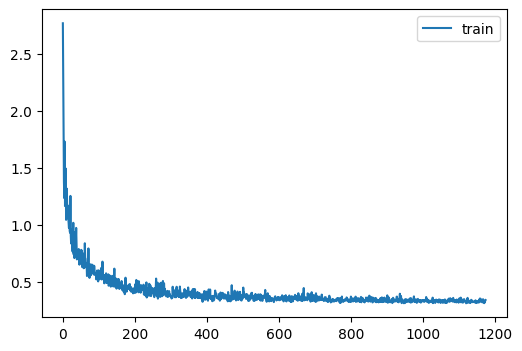

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [217]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[MixUp(0.05)]+cbs+xtra+[augcb], opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs + MixUp + rotation aug
learn.fit(epochs)

accuracy,loss,epoch,train
0.965,0.516,0,train
0.972,0.178,0,eval
0.984,0.362,1,train
0.985,0.107,1,eval
0.992,0.336,2,train
0.994,0.070,2,eval
0.997,0.322,3,train
0.995,0.065,3,eval
0.999,0.315,4,train
0.995,0.063,4,eval


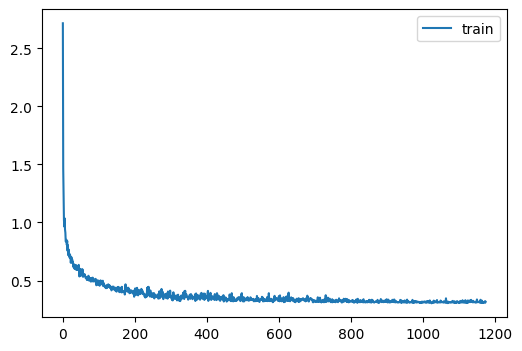

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [210]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[MixUp(0.05)]+cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs + MixUp
learn.fit(epochs)

accuracy,loss,epoch,train
0.964,0.694,0,train
0.984,0.164,0,eval
0.984,0.563,1,train
0.983,0.148,1,eval
0.988,0.483,2,train
0.989,0.143,2,eval
0.994,0.425,3,train
0.994,0.100,3,eval
0.997,0.398,4,train
0.994,0.091,4,eval


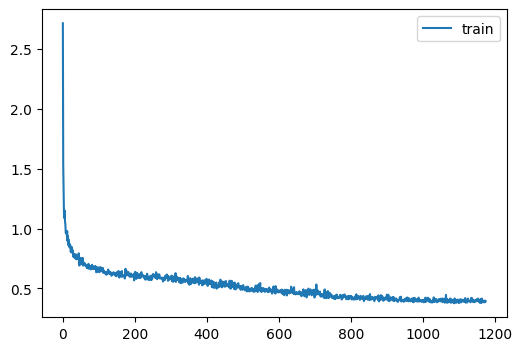

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [205]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[MixUp(0.05)]+cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs + MixUp(0.1)
learn.fit(epochs)

accuracy,loss,epoch,train
0.992,0.418,0,train
0.981,0.126,0,eval
0.987,0.429,1,train
0.988,0.083,1,eval
0.993,0.394,2,train
0.991,0.072,2,eval


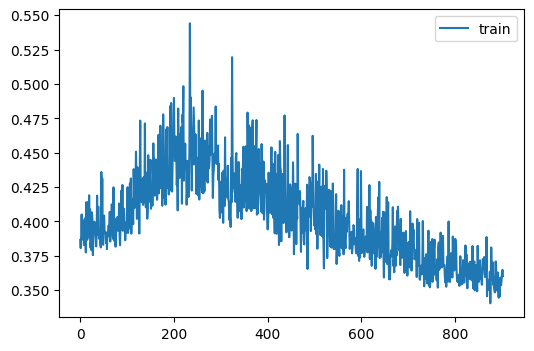

KeyboardInterrupt: 

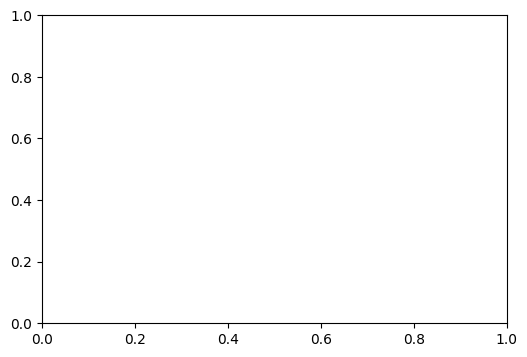

In [206]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[MixUp(0.1)]+cbs+xtra, opt_func=optim.AdamW)

# bs 64 + Mish + lr3e-2 + dropouts + aug 5 epochs 
learn.fit(epochs)

accuracy,loss,epoch,train
0.966,0.226,0,train
0.919,0.259,0,eval
0.979,0.079,1,train
0.985,0.058,1,eval
0.981,0.067,2,train
0.992,0.028,2,eval
0.995,0.019,3,train
0.995,0.017,3,eval
0.999,0.007,4,train
0.996,0.015,4,eval


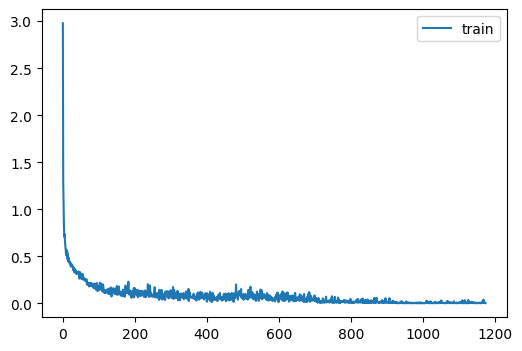

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [122]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs 
learn.fit(epochs)

accuracy,loss,epoch,train
0.966,0.256,0,train
0.969,0.130,0,eval
0.982,0.074,1,train
0.989,0.045,1,eval
0.990,0.040,2,train
0.985,0.052,2,eval
0.994,0.023,3,train
0.995,0.019,3,eval
0.998,0.010,4,train
0.995,0.017,4,eval


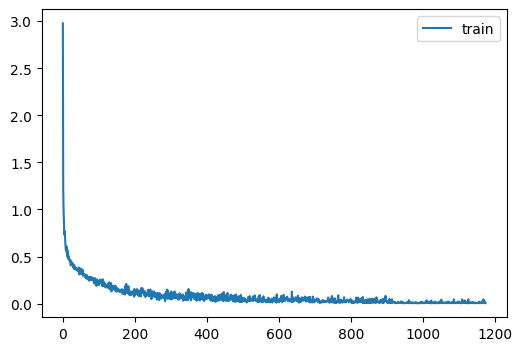

C:\ProgramData\Anaconda3\envs\invokeai\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [117]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs + orthogonal init

learn.fit(epochs)

accuracy,loss,epoch,train
0.967,0.260,0,train
0.973,0.101,0,eval
0.981,0.074,1,train
0.985,0.059,1,eval
0.989,0.041,2,train
0.990,0.037,2,eval
0.994,0.024,3,train
0.995,0.017,3,eval
0.998,0.010,4,train
0.996,0.015,4,eval


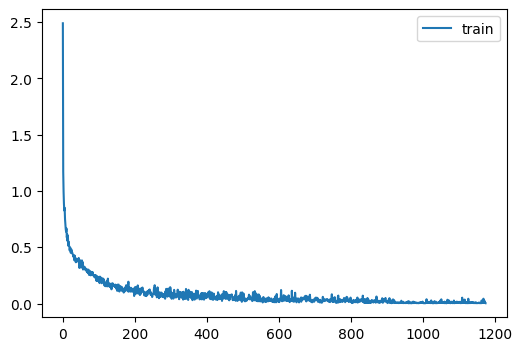

In [113]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + GeneralReLu + lr3e-2 + dropouts + aug 5 epochs

learn.fit(epochs)

accuracy,loss,epoch,train
0.965,0.266,0,train
0.968,0.116,0,eval
0.978,0.086,1,train
0.954,0.152,1,eval
0.981,0.071,2,train
0.987,0.046,2,eval
0.994,0.024,3,train
0.994,0.021,3,eval
0.998,0.010,4,train
0.996,0.018,4,eval


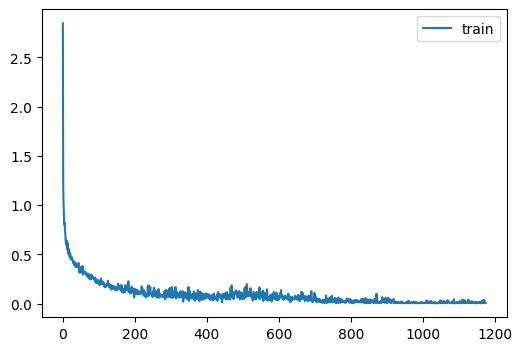

C:\ProgramData\Anaconda3\envs\invokeai\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [111]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + ReLU6 + lr3e-2 + dropouts + aug 5 epochs

learn.fit(epochs)

accuracy,loss,epoch,train
0.968,0.257,0,train
0.984,0.065,0,eval
0.982,0.072,1,train
0.985,0.054,1,eval
0.984,0.058,2,train
0.992,0.032,2,eval
0.996,0.018,3,train
0.995,0.018,3,eval
0.999,0.007,4,train
0.996,0.017,4,eval


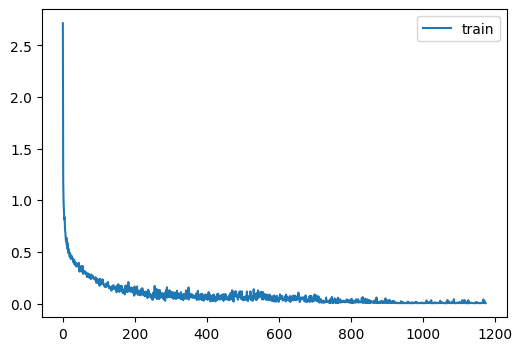

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [31]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr3e-2 + dropouts + aug 5 epochs

learn.fit(epochs)

accuracy,loss,epoch,train
0.967,0.302,0,train
0.980,0.106,0,eval
0.984,0.080,1,train
0.986,0.063,1,eval
0.986,0.056,2,train
0.993,0.027,2,eval
0.997,0.017,3,train
0.996,0.019,3,eval
0.999,0.009,4,train
0.996,0.018,4,eval


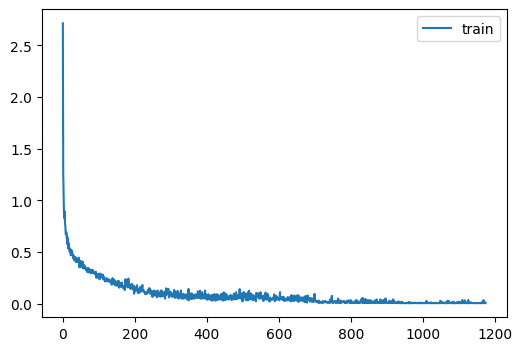

C:\Users\rohit\AppData\Local\Temp\ipykernel_31708\2428293066.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


In [28]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

# bs 256 + Mish + lr1e-2 + dropouts + aug 5 epochs

learn.fit(epochs)

### TTA

In [145]:
# TTA

class CapturePreds(Callback):
    def before_fit(self, learn): 
        self.all_preds, self.all_targs = [], []
        
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

cp = CapturePreds()
learn.fit(1, train=False, cbs=cp)

accuracy,loss,epoch,train
0.996,0.015,0,eval


In [146]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): 
    return tfm_x(b[0]), tfm_y(b[1])

In [147]:
cp2 = CapturePreds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=partial(TF.rotate, angle=5)), on_val=True)
learn.fit(1, train=False, cbs=[cp2, ttacb])

accuracy,loss,epoch,train
0.993,0.028,0,eval


In [148]:
ap1 = torch.cat(cp.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp.all_targs)
ap1.shape,ap2.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [149]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [150]:
round((ap==at).float().mean().item(), 3)

0.995

In [151]:
len(cp.all_preds[-1])

16

In [152]:
ap1.shape

torch.Size([10000, 10])

In [153]:
at.shape

torch.Size([10000])

In [154]:
predictions = ap1.argmax(1)

targets = at

predictions == targets

wrongidxs = []
for i in range(len(predictions)):
    if predictions[i] != targets[i]:
        wrongidxs += [i]
        
wrongidxs    

wrongidxs = []
for i in range(len(predictions)):
    if predictions[i] != targets[i]:
        wrongidxs += [i]
        
wrongidxs    

len(wrongidxs)

valitems = list(iter(dls.valid))

len(valitems)

testimgs = torch.cat([valitems[i][0] for i in range(len(valitems))])

testimgs.shape

for idx in wrongidxs:
    print("Prediction:", predictions[idx].item(), "Target:", targets[idx].item())
    plt.imshow(testimgs[idx][0]);
    plt.show()

Prediction: 2 Target: 8


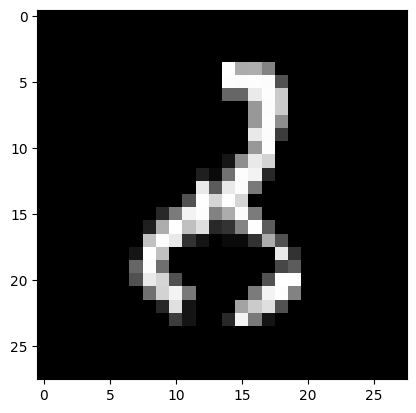

Prediction: 7 Target: 2


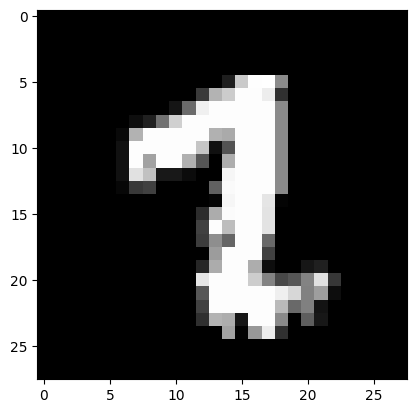

Prediction: 9 Target: 8


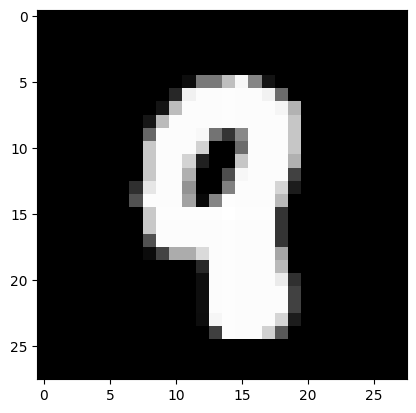

Prediction: 5 Target: 6


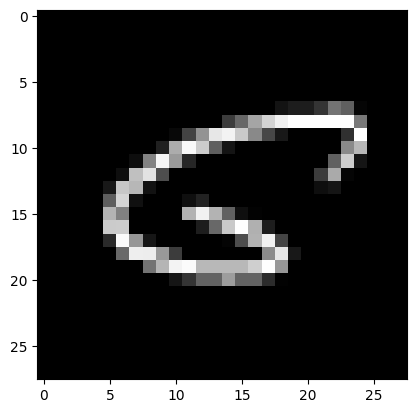

Prediction: 4 Target: 9


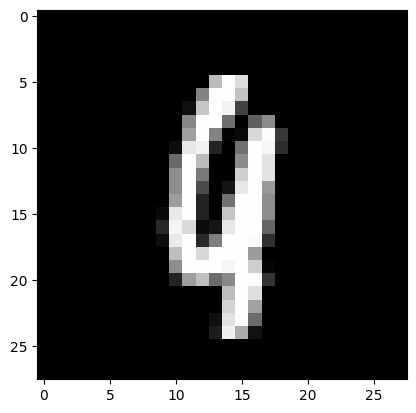

Prediction: 5 Target: 9


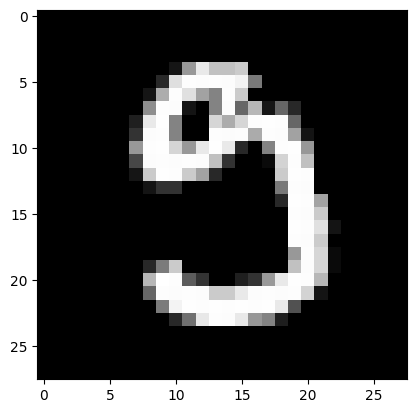

Prediction: 3 Target: 5


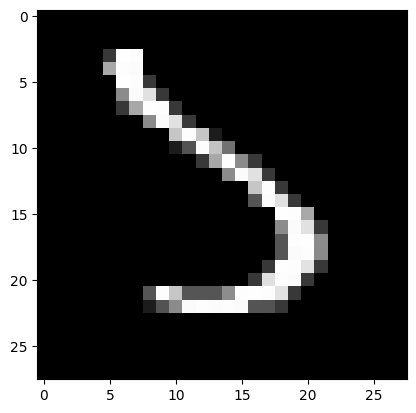

Prediction: 3 Target: 8


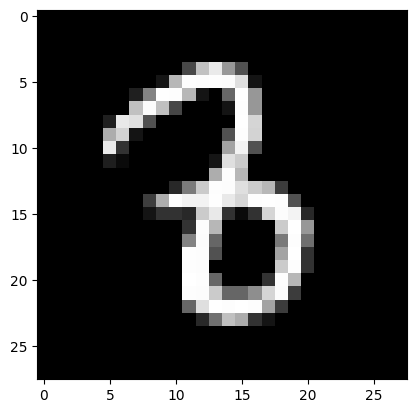

Prediction: 4 Target: 9


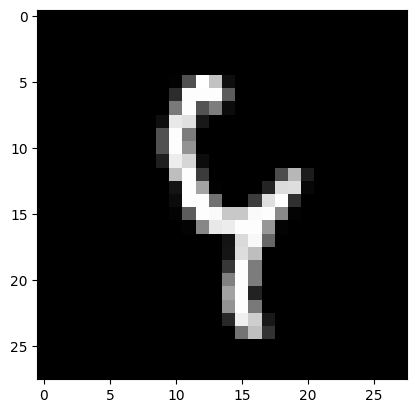

Prediction: 3 Target: 5


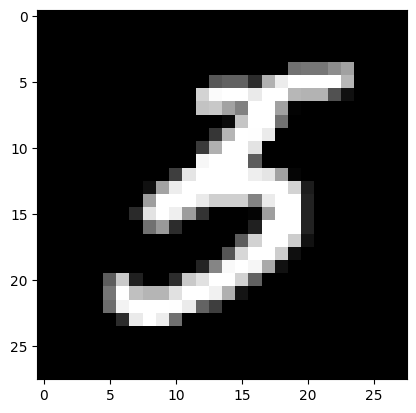

Prediction: 9 Target: 4


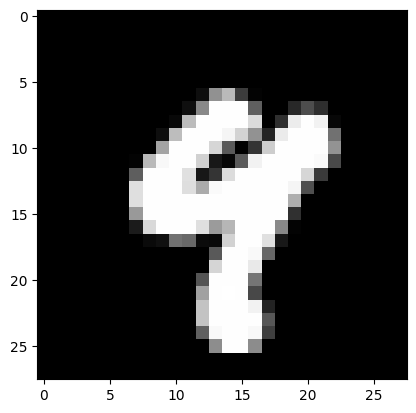

Prediction: 1 Target: 6


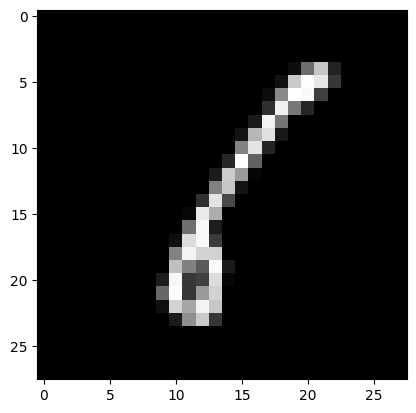

Prediction: 3 Target: 1


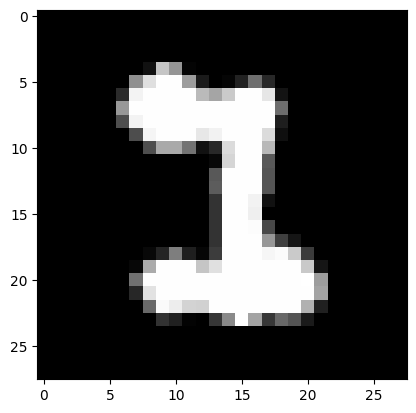

Prediction: 3 Target: 5


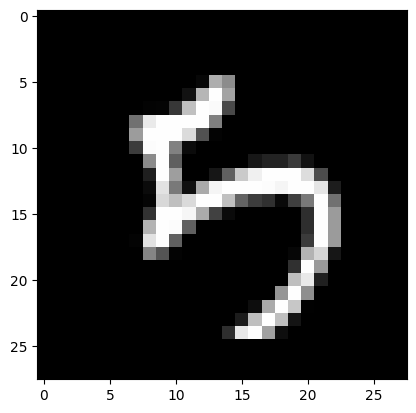

Prediction: 4 Target: 9


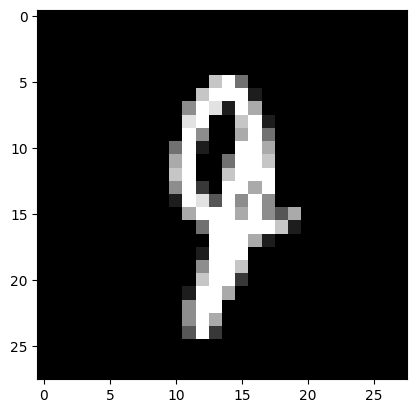

Prediction: 3 Target: 5


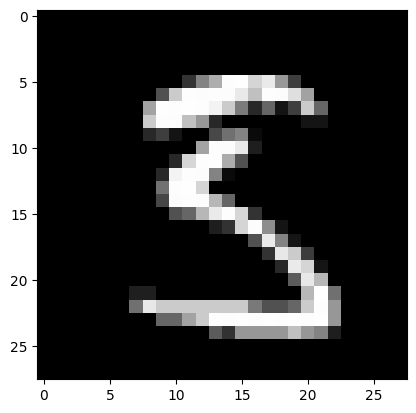

Prediction: 1 Target: 6


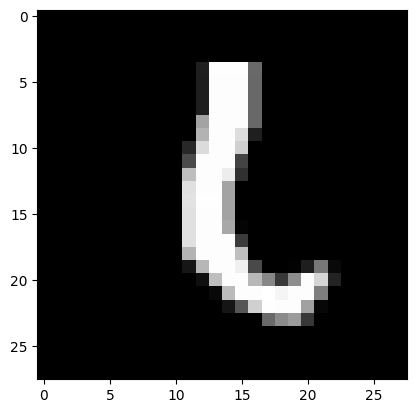

Prediction: 0 Target: 8


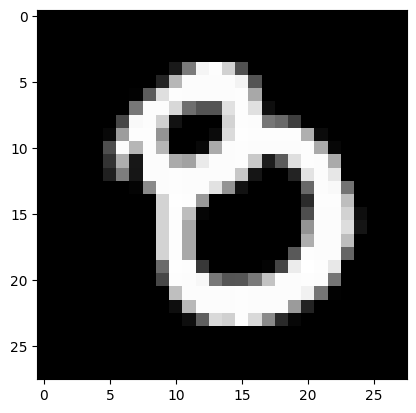

Prediction: 5 Target: 9


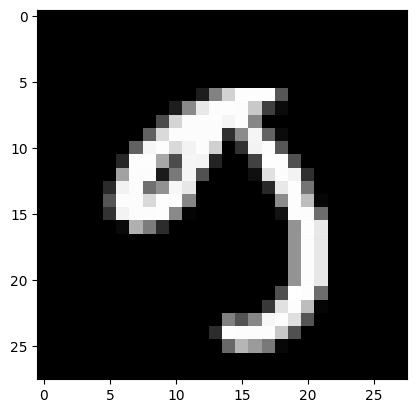

Prediction: 9 Target: 7


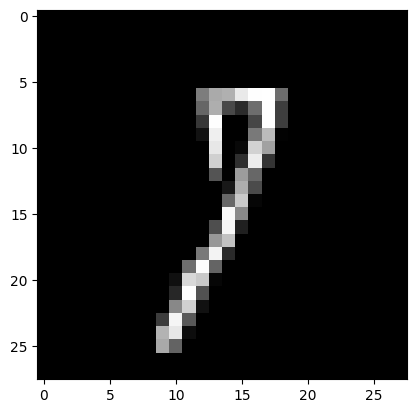

Prediction: 0 Target: 6


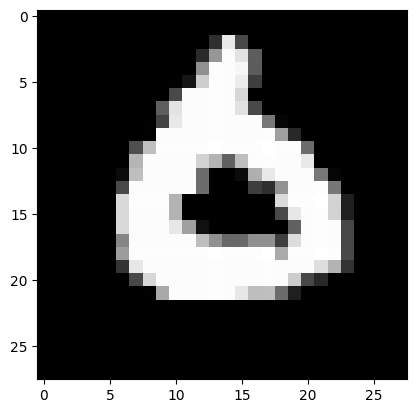

Prediction: 2 Target: 6


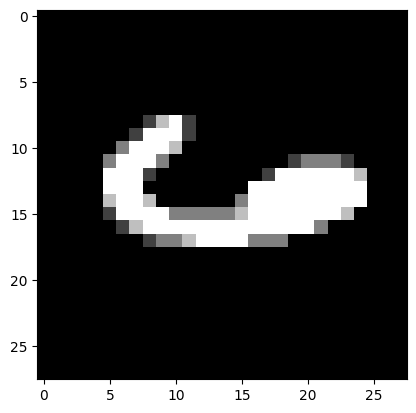

Prediction: 8 Target: 6


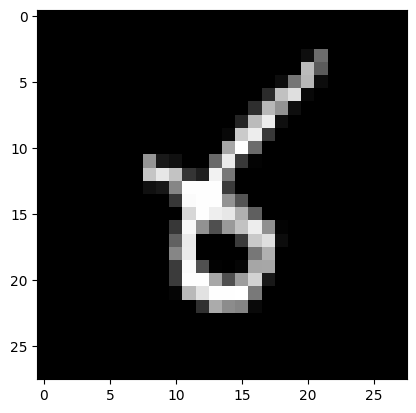

Prediction: 8 Target: 7


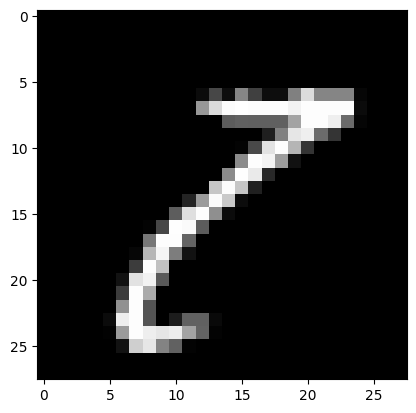

Prediction: 5 Target: 9


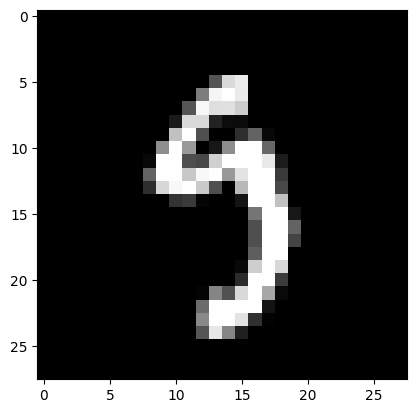

Prediction: 0 Target: 6


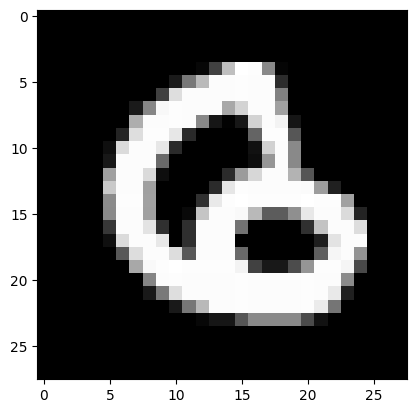

Prediction: 8 Target: 9


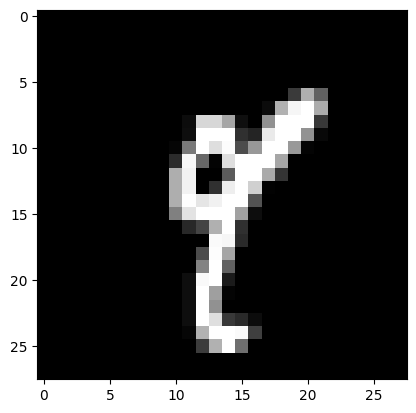

Prediction: 0 Target: 6


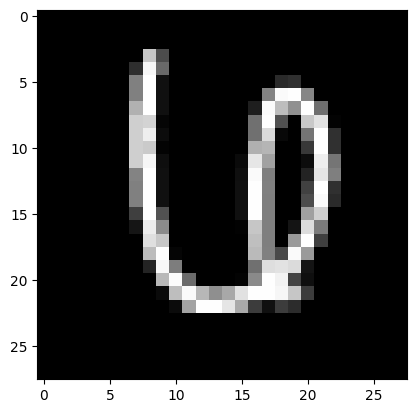

Prediction: 4 Target: 9


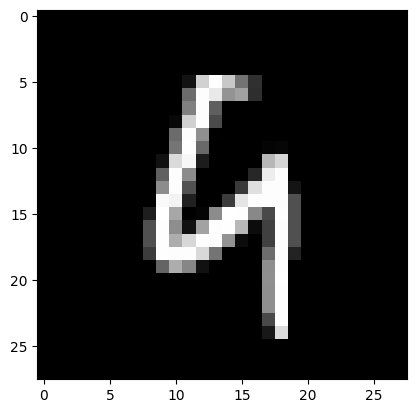

Prediction: 2 Target: 7


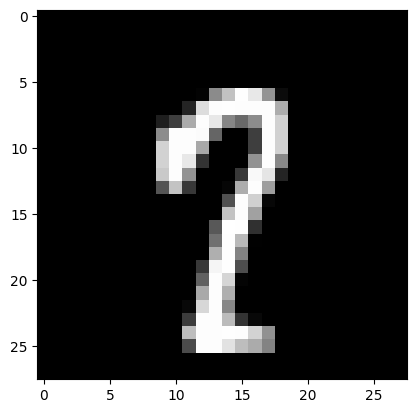

Prediction: 3 Target: 5


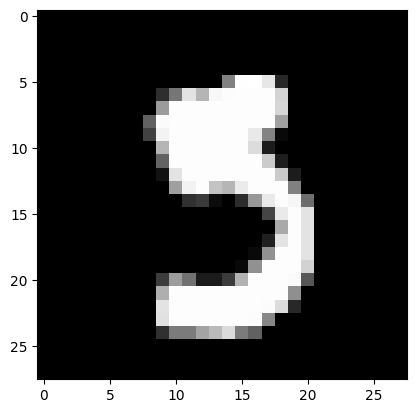

Prediction: 7 Target: 9


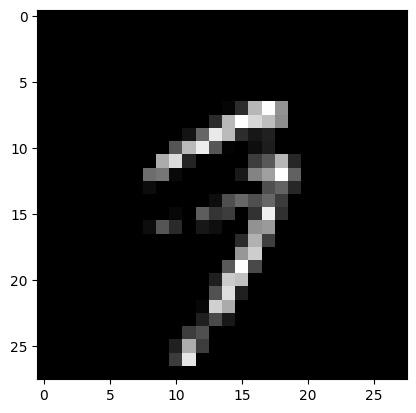

Prediction: 1 Target: 7


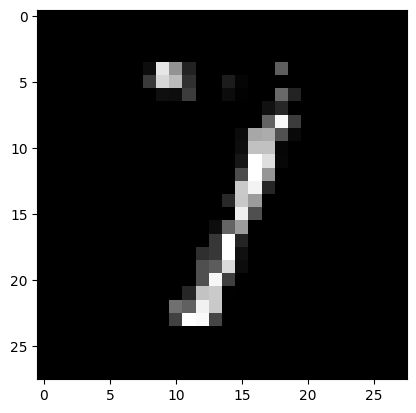

Prediction: 7 Target: 0


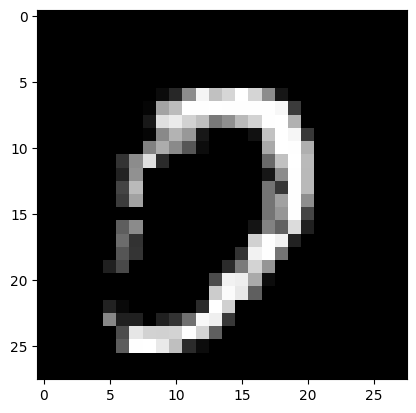

Prediction: 6 Target: 1


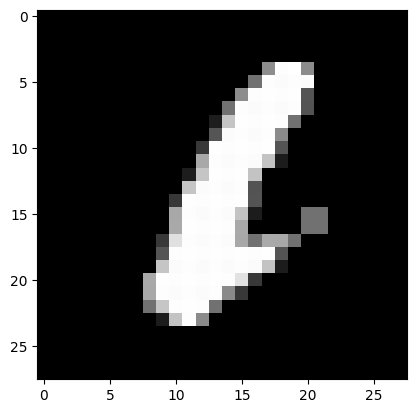

Prediction: 2 Target: 7


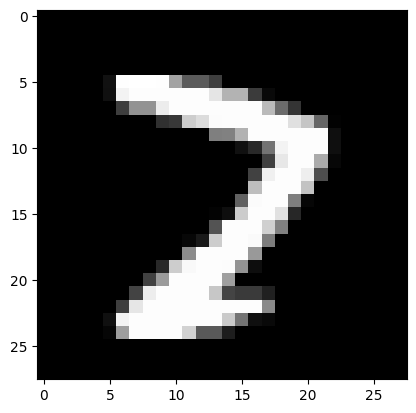

Prediction: 2 Target: 7


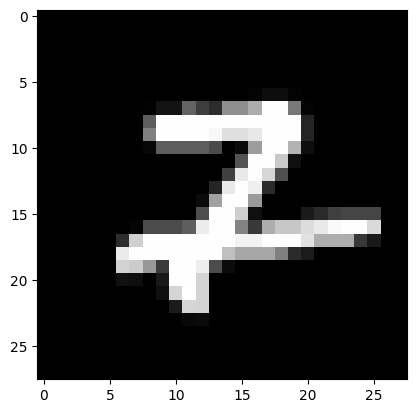

Prediction: 6 Target: 5


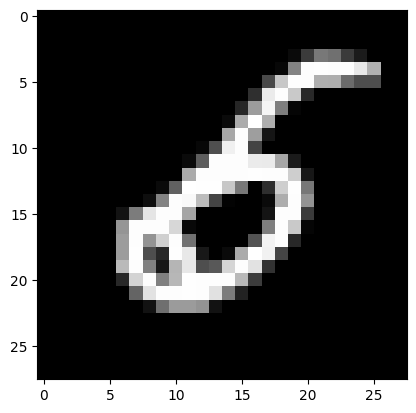

In [105]:
for idx in wrongidxs:
    print("Prediction:", predictions[idx].item(), "Target:", targets[idx].item())
    plt.imshow(testimgs[idx][0]);
    plt.show()